# statistical models
- Models take explanatory variables (x1, x2, ...) and output (predicted) response variables 
- the model is improved by comparing the observed variables to the predicted variables and 
minimize the difference betweenthe two

Models can useful to:
- reveal important qualities of   and/or trends in the population
- predict response variables for explanatory variables to come

# standard imports

In [1]:
import math

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pylab import rcParams

In [2]:
gapminder = pd.read_csv('data/gapminder.csv')

In [3]:
gdata = gapminder.query('year == 1985')

In [4]:
gdata.head()

,country,year,region,population,life_expectancy,age5_surviving,babies_per_woman,gdp_per_capita,gdp_per_day
50,Afghanistan,1985,Asia,11630498.0,45.21,78.400,7.68,1384.0,3.789185
131,Albania,1985,Europe,2966799.0,72.71,94.570,3.23,4267.0,11.682409
212,Algeria,1985,Africa,22565908.0,67.18,92.880,5.98,11030.0,30.198494
293,Angola,1985,Africa,9745209.0,47.50,77.170,7.21,4117.0,11.271732
374,Antigua and Barbuda,1985,America,65744.0,72.13,96.946,2.09,11383.0,31.164956


In [5]:
# display and store Matplotlib plots within a notebook
%matplotlib inline 
# rcParams ontrols the defaults of almost every property in Matplotlib
rcParams['figure.figsize'] = 10, 8 

In [6]:
size = 1e-6 * gdata.population

colors = gdata.region.map({'Africa': 'skyblue', 'Europe': 'gold', 'America': 'palegreen', 'Asia': 'coral'})

def plotdata():
    gdata.plot.scatter('age5_surviving','babies_per_woman',
                       c=colors,s=size,linewidths=0.5,edgecolor='k',alpha=0.5)

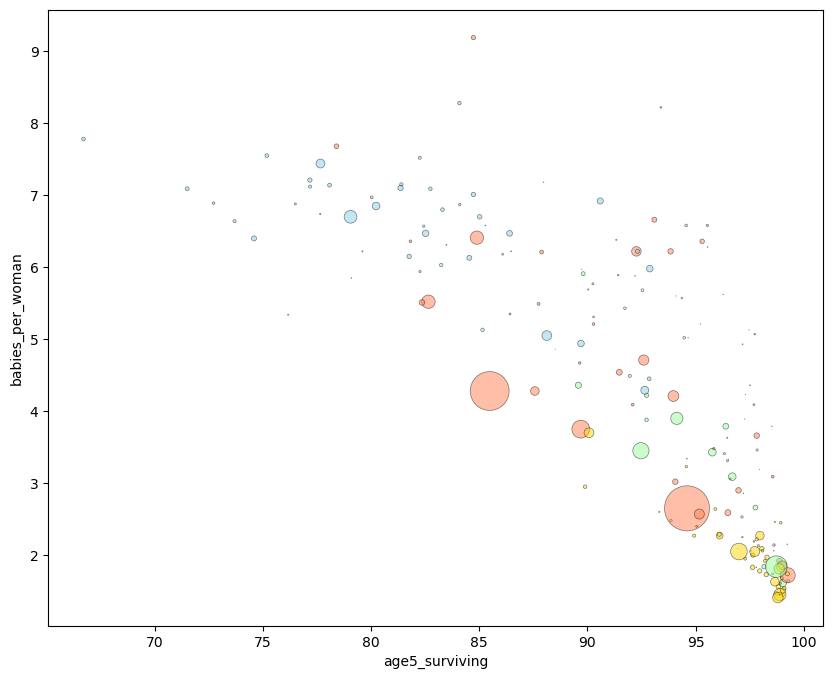

In [7]:
plotdata()

# OLS
- ordinary least squares - minimize the sum of squared residuals/differences between predictions and observations
- here ordinary means that the model coefficients appear linearly in the model formulas
- that is they multiply explanatory variables or functions of explanatory variables

## fitting a model
formula language
https://patsy.readthedocs.io/en/latest/formulas.html

In [8]:
# child survival rates vs babies per woman
# formula = response_variable ~ model_terms
# the intercept term (1) is invisible but we can write it explicitly as 1 
# if didn't want a intercept we can remove it with -1
model = smf.ols(formula='babies_per_woman ~ 1', data=gdata)
grandmean = model.fit()


In [11]:
def plotfit(fit):
    plotdata()
    plt.scatter(gdata.age5_surviving, fit.predict(gdata), 
    c=colors, s= 30, linewidths=0.5, edgecolor='k', marker='D')

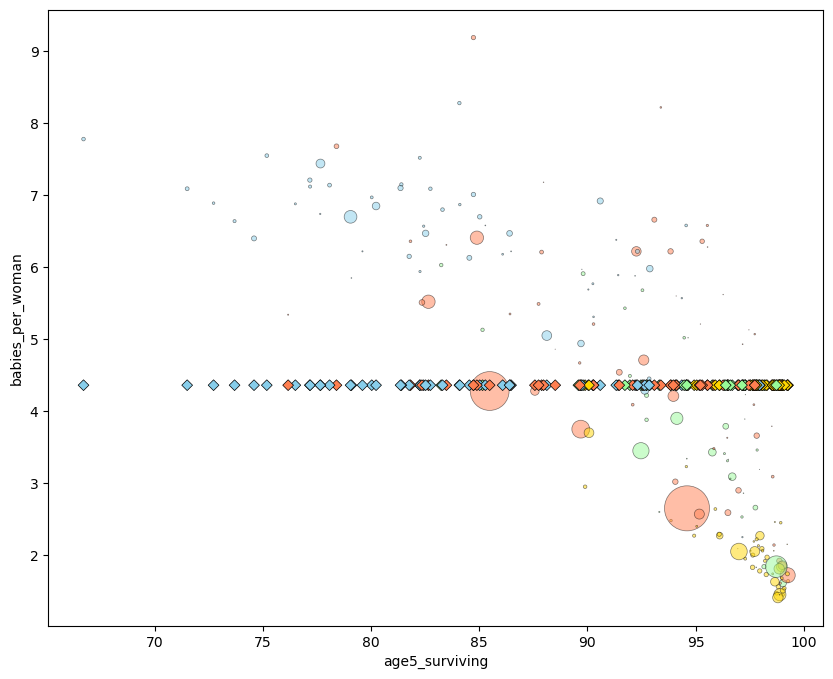

In [12]:
plotfit(grandmean)

In [13]:
# grandmean is the mean of all parameters
# it's the constant term of the model known as intercept
grandmean.params

Intercept    4.360714
dtype: float64

In [14]:
gdata.babies_per_woman.mean()

4.360714285714287

In [15]:
# if we introduce the region as model term
# we get the model equivalent to taking means by group
# new model terms are added in the formular via + model_term
groupmeans= smf.ols(formula='babies_per_woman ~ 1 + region', data=gdata).fit()

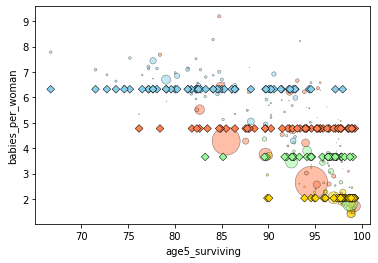

In [17]:
plotfit(groupmeans)

In [18]:
# we get a commomn constant term 
# and offsets for groups minus one of them 
# babies per woman in Europe: 6.321 - 4.285 = 2.036
groupmeans.params

Intercept            6.321321
region[T.America]   -2.663139
region[T.Asia]      -1.545744
region[T.Europe]    -4.285639
dtype: float64

In [19]:
# to treat all groups in the same way we write the formula with a minus 
groupmeans = smf.ols(formula='babies_per_woman ~ -1 + region', data=gdata).fit()

In [22]:
groupmeans.params

region[Africa]     6.321321
region[America]    3.658182
region[Asia]       4.775577
region[Europe]     2.035682
dtype: float64

In [23]:
# they are the same as the grouped means
gdata.groupby('region').babies_per_woman.mean()

region
Africa     6.321321
America    3.658182
Asia       4.775577
Europe     2.035682
Name: babies_per_woman, dtype: float64

In [24]:
surviving = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving',
                     data=gdata).fit()

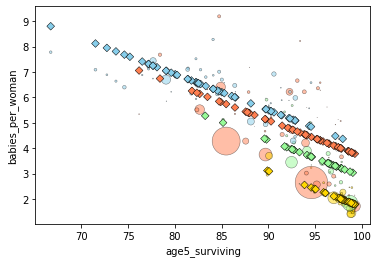

In [25]:
# the fit is improving with parameters
plotfit(surviving)

In [26]:
# age5_surviving tells us that that with every %point of child survival to age 5 
# the average babies per woman decrease by 0.14
# the intercepts are large now bc they represent a child survivial of 0% 
surviving.params

region[Africa]     18.265792
region[America]    17.085884
region[Asia]       17.864741
region[Europe]     15.872183
age5_surviving     -0.141886
dtype: float64

## model interaction term

In [27]:
# to have individual slopes for every group we have to throw in an interaction term 
# the interaction term is inserted with a colon :
surviving_byregion = smf.ols(formula='babies_per_woman ~ -1 + region + age5_surviving:region',
                    data=gdata).fit()

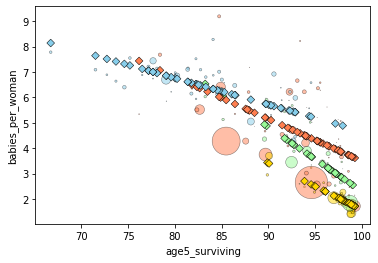

In [28]:
plotfit(surviving_byregion)

In [30]:
# we have a slope for every group now
# so far India and China seem to be outlieres according to the fit
surviving_byregion.params

region[Africa]                    15.080914
region[America]                   27.506243
region[Asia]                      20.032483
region[Europe]                    19.884446
age5_surviving:region[Africa]     -0.104053
age5_surviving:region[America]    -0.251994
age5_surviving:region[Asia]       -0.165384
age5_surviving:region[Europe]     -0.183029
dtype: float64

In [31]:
# including population as explanatory variable
surviving_byregion_population = smf.ols(
    formula='babies_per_woman ~ -1 + region + age5_surviving:region + population',
    data=gdata).fit()

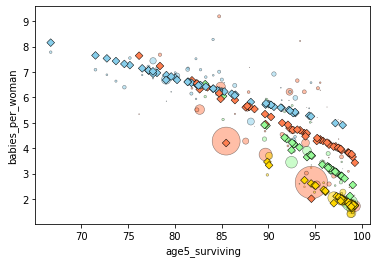

In [32]:
plotfit(surviving_byregion_population)

# goodness of fit

- mean square error of residuals **MSE**
- **$R^2$**
- $F$-statistics
- ANOVA tabels

$MSE = \frac{1}{n} \sum(\hat{y_i} − y_i)^2$

**$R^2$** = $\frac{explanined \, variance}{total \, variance}$ = $1- \frac{SSE}{SST}$ <br>
the proportion of explained y-variability <br>
Sum of Squared Error (SSE) = $\sum (y_i − \hat{y_i})^2$ <br>
Total Sum of Squares (SST) = $\sum (y_i − \bar{y})^2$

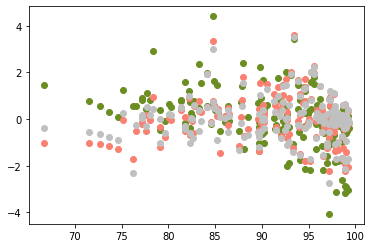

In [61]:
# grouped by region
plt.scatter(gdata.age5_surviving, groupmeans.resid, color='olivedrab')
# region + child survival
plt.scatter(gdata.age5_surviving, surviving.resid, color='salmon')
# region + survival + population
plt.scatter(gdata.age5_surviving, surviving_byregion_population.resid, color='silver')

In [62]:
# MSE of different models
for model in [groupmeans, surviving, surviving_byregion, surviving_byregion_population]:
    print(model.mse_resid)

1.4979520263709154
0.9423025333008324
0.8995512597945947
0.8480227300570339


In [63]:
# R^2 of the models
for model in [ groupmeans, surviving, surviving_byregion, surviving_byregion_population ]:
    print(model.rsquared)

0.636467696559659
0.7726009080146058
0.7865971252318769
0.7999775707885213


## $F$-statistics
- takes not only explained and unexplained variances but the number of model parameters into consideration
- explanatory power of fit parameters compared to 'random' fit vectors
- too many parameters will overfit the data, loosing predictive power
- F-statistic measures how much a model parameter contributes to the improvement of $R^2$ <br>
compared to a random model vector with no link to the response variable 
- F=1 means that a parameter contributes the same to $R^2$ as a random vector
- a large F means that the parameter has a great explanatory value 
- The F value in regression is the result of a test where the $H_0$ states that all of the regression coefficients <br>
are equal to zero. In other words, the model has no predictive capability. 
- Basically, the f-test compares your model with zero predictor variables (the intercept only model), <br>
and decides whether your added coefficients improved the model. If you get a significant result, <br>
then whatever coefficients you included in your model improved the model’s fit. 

In [65]:
# F-statistics - surviving seems to hit a sweet spot
for model in [groupmeans, surviving, surviving_byregion, surviving_byregion_population]:
    print(model.fvalue)

103.88003937611687
150.34180603430977
91.62274469897298
86.48787556725166


In [66]:
# model summary
surviving.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       babies_per_woman   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     150.3
Date:                Sat, 20 Aug 2022   Prob (F-statistic):           8.26e-56
Time:                        14:07:39   Log-Likelihood:                -250.30
No. Observations:                 182   AIC:                             510.6
Df Residuals:                     177   BIC:                             526.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
region[Africa]     18.2658      1.168     15.639      0.000      15.961      20.571
region[America]    17.0859      1.315     12.990      0.000      14.490      19.682
region[Asia]       17.8647      1.279     13.971      0.000      15.341      20.388
region[Europe]     15.8722      1.352     11.739      0.000      13.204      18.541
age5_surviving     -0.1419      0.014    -10.294      0.000      -0.169      -0.115
==============================================================================
Omnibus:                       13.021   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               18.362
Skew:                           0.443   Prob(JB):                     0.000103
Kurtosis:                       4.279   Cond. No.                     3.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## ANOVA table

- df/region = parameters
- df/residual = datapoints - df
- sum_sq = SST
- mean_sq = MSE
- explanatory value of the parameter
- PR(>F) = p-value of a Null model with the same params as ours, but all the terms are random

In [67]:
sm.stats.anova_lm(groupmeans)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,655.512121,2.604302e-105
Residual,178.0,266.635461,1.497952,NaN,NaN


In [68]:
# age5_survival explains a lot less of the variance than the region
# but F is still high for age5_surviving
sm.stats.anova_lm(surviving)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,1042.049316,8.236854e-122
age5_surviving,1.0,99.847912,99.847912,105.961630,9.003514e-20
Residual,177.0,166.787548,0.942303,NaN,NaN


In [70]:
# the F-statistics are now shared by region 
sm.stats.anova_lm(surviving_byregion_population)

,df,sum_sq,mean_sq,F,PR(>F)
region,4.0,3927.702839,981.925710,1157.900225,1.132132e-123
age5_surviving:region,4.0,110.113541,27.528385,32.461848,3.514845e-20
population,1.0,9.813987,9.813987,11.572788,8.313090e-04
Residual,173.0,146.707932,0.848023,NaN,NaN


# Cross Validation
- Dataset is split in training and testing data
- the training-set is used to fit a model
- the testing set is used to evaluate the models prediction error
- classical methods for goodness of fit (OLS) concentrate on in-sample errors
- **CV focuses on out-of-sample prediction error**
- models that are trained on one dataset can't look better by overfitting 
- the validation with the test-set will expose the overfit
- in reality k-fold CV is used
- k-fold cross-validation: dividing the data into k subsets, and then using k successive trials to train and test 
- This functionality is supported by "sklearn"

In [71]:
gapminder = pd.read_csv('data/gapminder.csv')
gdata = gapminder.query('year == 1985')

Refactored plotting so that it works on arbitrary datasets.

In [72]:
def sc(data):
    return 1e-6 * data.population, data.region.map({'Africa': 'skyblue', 'Europe': 'gold',
                                                   'America': 'palegreen', 'Asia': 'coral'})

def plotdata(data=gdata):
    size, colors = sc(data)
    data.plot.scatter('age5_surviving','babies_per_woman',
                      c=colors, s=size, linewidths=0.5, edgecolor='k', alpha=0.5)
                      
def plotfit(fit, data=gdata):
    plotdata(data)
    size, colors = sc(data)
    plt.scatter(data.age5_surviving, fit.predict(data),
               c=colors, s=30, linewidths=0.5, edgecolor='k', marker='D')

In [91]:
f_groupmeans = 'babies_per_woman ~ -1 + region'
f_surviving = 'babies_per_woman ~ -1 + region + age5_surviving'
f_srp = ('babies_per_woman ~ -1 + region + age5_surviving + age5_surviving:region - age5_surviving + population')

In [75]:
# before dividing the dataset we shuffel it, 
# the resulting data set should have the same lenght as the original
shuffled = gdata.sample(len(gdata))

In [76]:
# split data set in two
training, testing =shuffled.iloc[ : len(gdata)//2], shuffled.iloc[len(gdata)//2 : ]

In [1]:
surviving = smf.ols(f_surviving, data=training).fit()

NameError: name 'smf' is not defined

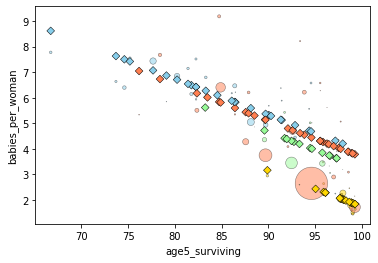

In [78]:
# predictions vs trainig data
plotfit(surviving, training)

In [80]:
surviving.mse_resid

1.1259292449684684

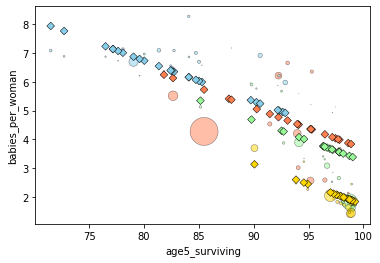

In [81]:
# prediction vs testing data
plotfit(surviving, testing)

In [83]:
# obtain the MSE
# residuals = prediction - observations
# degrees of freedom = lenght of data minus paramters in the model minus 1 for the constant 
# MSE = residuals^2 / df
resid = surviving.predict(testing) - testing.babies_per_woman
df = len(testing) - surviving.df_model -1
np.sum(resid**2) / df

0.8794111550558957

In [87]:
def cross_validation(data, formula, response, n=100):
    ret = []

    for i in range(n):
        shuffeled = data.sample(len(data)) # shuffel data set

        # train-test split
        training, testing = shuffled.iloc[:len(data) // 2], shuffled.iloc[len(data) // 2:]
        trained = smf.ols(formula, data=training).fit() # fit model

        resid = trained.predict(testing) - testing[response] # pridictions - observations
        df = len(testing) - trained.df_model - 1  # degrees of freedom
        mse = np.sum(resid**2) / df # mse

        ret.append(mse)  # collect mse for different models

    # return the mean of means of n different train-test & fit model  procedures
    return np.mean(ret)

In [88]:
cross_validation(gdata, f_groupmeans, 'babies_per_woman')

1.4244473660337595

In [89]:
cross_validation(gdata, f_surviving, 'babies_per_woman')

0.8794111550558955

In [92]:
cross_validation(gdata, f_srp, 'babies_per_woman')

0.8202483042969

# logistic regression
- model fitting with categorical response values
- standard linear model outputs values from $-\infty$ to $+\infty$
- via **logistic transformation** $\frac{exp(y)}{1+exp(y)}$ we can limit the interval to $[0, 1]$  <br>
which can be interpreted as a probability

In [13]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 15 ("                               'fc4f30', ")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 16 ("                               'e5ae38',")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 17 ("                               '6d904f',")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 18 ("                               '8b8b8b',")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 19 ("                               '810f7c'])")
Bad value in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 14 ("axes.prop_cycle: cycler(color=['008fd5', "): Key axes.prop_cycle: 'cycler(color=['008fd5',' is not a valid cycler construction: unexpected EOF while parsing (<unknown>, 

In [ ]:
# fix error in some versions of statsmodels
import scipy
if not hasattr(scipy.stats, 'chisqprob'):
    scipy.stats.chisqprob = lambda chisq, df: scipy.stats.chi2.sf(chisq, df)

In [4]:
smoking = pd.read_csv("data/whickham.csv")

In [5]:
smoking = smoking[smoking.age < 65]

In [8]:
color = np.where(smoking.smoker == 'No', 'skyblue', 'coral')
# jitter prevents points from lie on top of each other
jitter = 0.05*(np.random.rand(len(smoking)) -0.5)
def plotfit(fit):
    plt.scatter(smoking.age, smoking.outcome + jitter, c=color, linewidth=0.2, edgecolor='k', alpha=0.5)
    plt.scatter(smoking.age, fit.predict(smoking), c=color, linewidth=0.2, edgecolor='gray', marker='d')

In [9]:
# multplying a boolean with an integer returns an integer
# Alive = 1
smoking['outcome'] = 1* (smoking['outcome'] == 'Alive')

In [10]:
smoking.head(2)

,outcome,smoker,age
0,1,Yes,23
1,1,Yes,18


In [11]:
# Alive as a response variable explained through smoking(yes/no) and age
ols_group_age = smf.ols('outcome ~ smoker + age', data=smoking).fit()

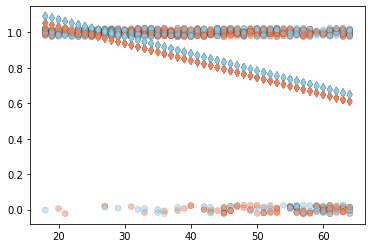

In [14]:
# non-smoker= light blue
# predictions are Diamond shaped and show a downward slope 
# the plot shows a problem: some predicted outcomes  > 1
plotfit(ols_group_age)

In [101]:
# smoking has a negative impact on being Alive (-0.038)
ols_group_age.params

Intercept        1.264665
smoker[T.Yes]   -0.038738
age             -0.009615
dtype: float64

In [15]:
# F-statsistic for smoker term is not really strong (8.18)
sm.stats.anova_lm(ols_group_age)

,df,sum_sq,mean_sq,F,PR(>F)
smoker,1.0,0.899981,0.899981,8.181417,4.314608e-03
age,1.0,17.713821,17.713821,161.030213,1.806638e-34
Residual,1068.0,117.483303,0.110003,NaN,NaN


In [105]:
# the CI calculation makes specific assumptions about the data 
# they should thus taken with a grain of salt
ols_group_age.conf_int()

,0,1
Intercept,1.198828,1.330503
smoker[T.Yes],-0.078622,0.001146
age,-0.011102,-0.008129


## logistic model
- the model is bounded [0, 1]
- displays a non-linear behaviour
- the criterion of the log model is not min(MSE) <br>
but rather interpreting the model response as a <br>
probability function and maximizing the resulting probability of the observed data
- it is a form of maximimum likelihood estimation
- thus to characterize the goodness of fit is the value of the Likelihood

In [107]:
logit_smoker_age = smf.logit('outcome ~ smoker +  age', data=smoking).fit()

Optimization terminated successfully.
         Current function value: 0.346766
         Iterations 7


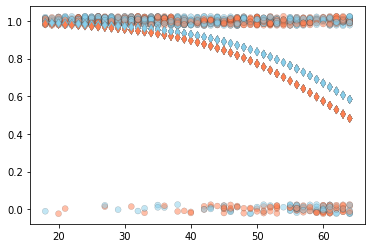

In [108]:
plotfit(logit_smoker_age)

In [110]:
# Log-likelihood of model
logit_smoker_age.llf

-371.38650786619064

In [111]:
# bc of the log transformation the params are not 
# directly comparable with the ols params
# smoking reduces the chance of being alive not uniformly 
# the higher the age the stronger the negative effect of smoking
logit_smoker_age.params

Intercept        6.250847
smoker[T.Yes]   -0.408103
age             -0.092403
dtype: float64

In [124]:
logit_smoker_age.conf_int()

,0,1
Intercept,5.331126,7.170568
smoker[T.Yes],-0.777754,-0.038451
age,-0.109478,-0.075327


- the logistic models probabilities are conditional probabilities
- they depend on the values of the explanatory variables<br>
and they refer directly to the cases in the data set but not  <br>
neccessarily to the general population unless we can determine <br>
that the sample is truly representative of the population

In [125]:
logit_smoker_age.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                outcome   No. Observations:                 1071
Model:                          Logit   Df Residuals:                     1068
Method:                           MLE   Df Model:                            2
Date:                Sat, 20 Aug 2022   Pseudo R-squ.:                  0.1776
Time:                        23:23:14   Log-Likelihood:                -371.39
converged:                       True   LL-Null:                       -451.59
Covariance Type:            nonrobust   LLR p-value:                 1.469e-35
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         6.2508      0.469     13.321      0.000       5.331       7.171
smoker[T.Yes]    -0.4081      0.189     -2.164      0.030      -0.778      -0.038
age              -0.0924      0.009    -10.606      0.000      -0.109      -0.075
=================================================================================
"""

# bayesian inference
- instead of making estimates of populations parameters from the data
we maintain probability distributions for population distributions, which represent our quantative belief about their value
- starting with a pior probability (what we know so far) and with the use of observations we update the prior to a probability posterior 


- new and improved belief = Initial belief plus new evidence <br><br>
- $P(A|B) = \frac{P(B|A) \,P(A)}{P(B)}$
- $P(A|B)$: Posterior, conditional prob. of A being true, given B  is true
- $P(B|A)$: Likelihood, conditional prob. of B being true, given A is true
- $P(A)$: Prior, prob. of A bing true, this is the initial knowledge
- $P(B)$: Marginalization, prob of B being true

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pymc as pm

Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 15 ("                               'fc4f30', ")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 16 ("                               'e5ae38',")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 17 ("                               '6d904f',")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 18 ("                               '8b8b8b',")
Missing colon in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 19 ("                               '810f7c'])")
Bad value in file PosixPath('/home/mz/.config/matplotlib/stylelib/scientific.mplstyle'), line 14 ("axes.prop_cycle: cycler(color=['008fd5', "): Key axes.prop_cycle: 'cycler(color=['008fd5',' is not a valid cycler construction: '[' was never closed (<unknown>, line 1)


In [2]:
# with a coin toss we have the suspicion that the coin is not fair
n = 100 # 100 tosses
k = 61 # observed outcome

with pm.Model() as coin_context:
    # prior: we suspect head 40% to 80% of times instead of 50%
    p = pm.Uniform('p', 0.4, 0.8)
    # observations: binomial decribes the prob. of observing k events 
    # over n trials if each event has a prob. p
    y = pm.Binomial('y', n=n, p=p, observed=k)
    # sampling the posterior: generate a large set of sample params wich will be 
    # approximately distributed according to the posterior its called trace
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 7 seconds.
The acceptance probability does not match the target. It is 0.8846, but should be close to 0.8. Try to increase the number of tuning steps.


In [3]:
# mean: most probable value for the biasedness of the coin
# highest density interval hdi of posterior distributions. 
# All points within the hdi interval have a higher probability density than 
# points outside the interval. The HDI can be used in the context of uncertainty 
# characterisation of posterior distributions as Credible Interval (CI).
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.607,0.048,0.515,0.696,0.0,0.0,17283.0,24882.0,1.0


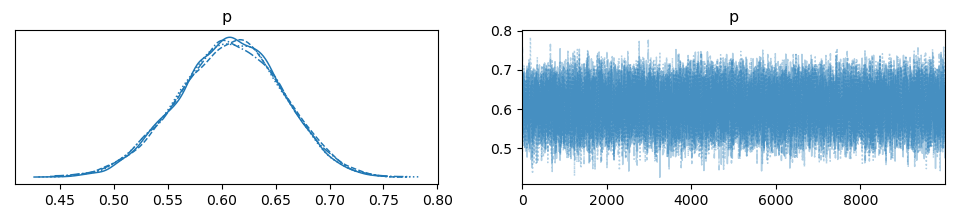

In [6]:
# the plot on the right shows all the values taken on by the parameter p
pm.plot_trace(trace);

In [9]:
gdata=pd.read_csv('../../MaCoZu/data/gapminder.csv').query('year==1985')

In [10]:
gdata.sort_values('age5_surviving', inplace=True)

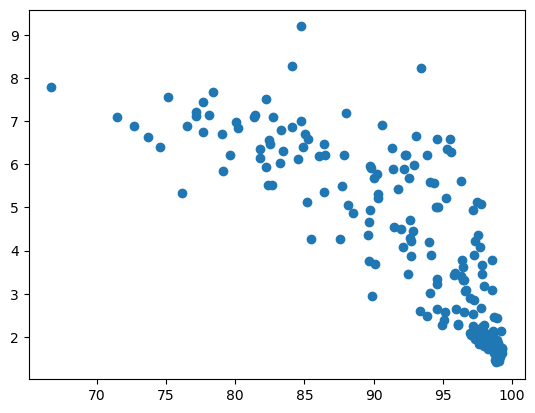

In [11]:
plt.scatter(gdata['age5_surviving'], gdata['babies_per_woman'])

In [23]:
# we'll reproduce teh downward slope
with pm.Model() as gapminder_context:
    # priors: 
    # intercept is between 5 and 15, this can be guessed from the plot
    intercept = pm.Uniform('intercept', 5, 15)
    # slope can also be approximated looking at the plot
    slope = pm.Uniform('slope', -1, 1)

    # observations are typically assimilated using normal dist with mean set to intercept +slope * data[x]
    # and std set to measurement error
    babies = pm.Normal('babies', 
                        # center of the normal dist is the intercept + slope * explanatory var (refering to 65%)
                        mu = intercept + slope * (gdata['age5_surviving'] - 65),
                        sigma = 1,
                        observed =gdata['babies_per_woman'])     
    
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 15 seconds.
The acceptance probability does not match the target. It is 0.6956, but should be close to 0.8. Try to increase the number of tuning steps.


In [24]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,10.192,0.28,9.656,10.706,0.003,0.002,6889.0,8044.0,1.0
slope,-0.219,0.01,-0.238,-0.200,0.000,0.000,7006.0,8284.0,1.0


array([[<AxesSubplot:title={'center':'intercept'}>,
        <AxesSubplot:title={'center':'intercept'}>],
       [<AxesSubplot:title={'center':'slope'}>,
        <AxesSubplot:title={'center':'slope'}>]], dtype=object)

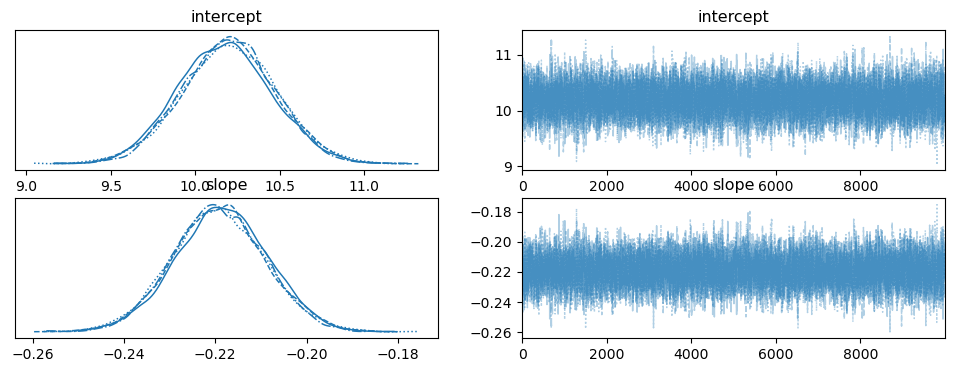

In [25]:
pm.plot_trace(trace)

In [51]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [47]:
# extracting the posteriors for intercept and mean and taking the mean
slope_mean = float(trace.posterior.variables['slope'].mean())
intercept_mean = float(trace.posterior.variables['intercept'].mean())
intercept_mean, slope_mean

(10.191881964219947, -0.21911392250546605)

In [48]:
# bayesian fit 
babies = intercept_mean + slope_mean * (gdata['age5_surviving'] - 65)

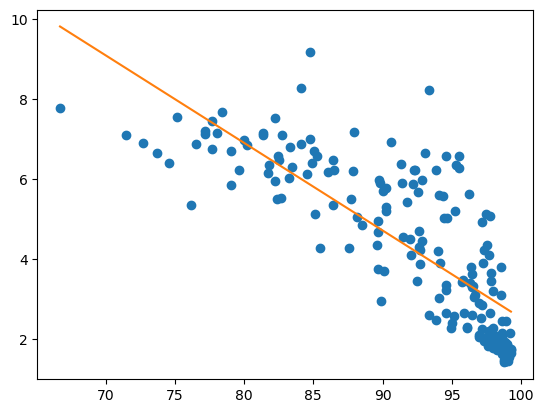

In [50]:
plt.scatter(gdata['age5_surviving'], gdata['babies_per_woman']);
plt.plot(gdata['age5_surviving'], babies, 'C1');

In [59]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [80]:
# infact every point in the posterior
# corresponds to a slightly different model
# extract slope and intercept draws from PyMC trace
intercepts = trace.posterior.variables['intercept'][0].to_numpy()
slopes = trace.posterior.variables['slope'][0].to_numpy()

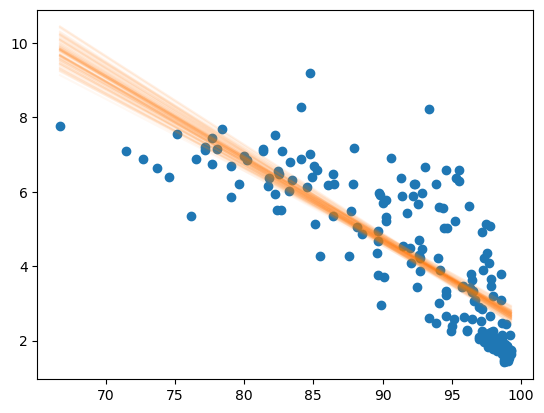

In [82]:
plt.scatter(gdata['age5_surviving'], gdata['babies_per_woman'])

for i, intercept, slope in zip(range(100), intercepts[::50], slopes[::50]):
    babies = intercept + slope * (gdata['age5_surviving'] - 65)
    plt.plot(gdata['age5_surviving'], babies, 'C1', alpha=0.05)